# MNIST digit recognition using neural network with dropouts
To perform training and testing without using high-level neural network library. Most of the code is written to explain how the neural network works with dropouts.

3 layers NN:
* algebric formula for neural network architecture: $l_2 = softmax(tanh(l_0 W_0) W_1)$

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")

In [3]:
# Verify that the dataset is as per the description provided
print("Train dataset dimensions: {}".format(df_train.shape))
print("Training dataset samples:\n", df_train.head())
print("\nTest dataset dimensions: {}".format(df_test.shape))
print("Test dataset samples:\n", df_test.head())

Train dataset dimensions: (42000, 785)
Training dataset samples:
    label  pixel0  pixel1    ...     pixel781  pixel782  pixel783
0      1       0       0    ...            0         0         0
1      0       0       0    ...            0         0         0
2      1       0       0    ...            0         0         0
3      4       0       0    ...            0         0         0
4      0       0       0    ...            0         0         0

[5 rows x 785 columns]

Test dataset dimensions: (28000, 784)
Test dataset samples:
    pixel0  pixel1  pixel2    ...     pixel781  pixel782  pixel783
0       0       0       0    ...            0         0         0
1       0       0       0    ...            0         0         0
2       0       0       0    ...            0         0         0
3       0       0       0    ...            0         0         0
4       0       0       0    ...            0         0         0

[5 rows x 784 columns]


In [4]:
Y_train = df_train["label"]
# From training dataset, remove "label" column to use that as input to the network
X_train = df_train.drop(labels=["label"], axis=1)
X_test = df_test

In [5]:
# How do training and test images look like?
# First, lets convert images into 28x28 matrix; 
X_train_samples = X_train[0:9].values.reshape(-1, 28, 28)
X_test_samples = df_test[0:9].values.reshape(-1, 28, 28)

Training dataset sample images:


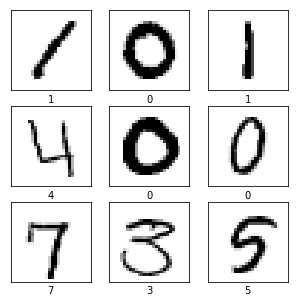

In [6]:
# For 9 sample images from training dataset, plot them in 3 by 3
print("Training dataset sample images:")
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_samples[i], cmap=plt.cm.binary)
    plt.xlabel(Y_train.iloc[i])
plt.show()

Test dataset sample images:


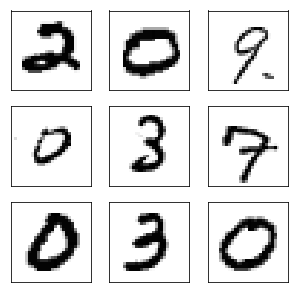

In [7]:
# For 9 sample images from training dataset, plot them in 3 by 3
print("Test dataset sample images:")
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_samples[i], cmap=plt.cm.binary)
plt.show()

In [8]:
# Normalize the dataset. All pixel values will fall between [0, 1]
X_train = X_train/255.0

While training, check how the model fits to validation set

In [9]:
# Create a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3)
# Create one-hot vectors for all Y_train
one_hot_labels = np.zeros((Y_train.shape[0], 10))
for index, label in enumerate(Y_train):
    one_hot_labels[index][label] = 1
train_labels = one_hot_labels

# Create one-hot vectors for validation set Y_val
one_hot_labels = np.zeros((Y_val.shape[0], 10))
for index, label in enumerate(Y_val):
    one_hot_labels[index][label] = 1
val_labels = one_hot_labels

In [10]:
def tanh(x):
    """Hidden layer activation function"""
    return np.tanh(x)

def tanh_derivative(output):
    """Slop information for backpropogation"""
    return 1 - (output ** 2)

def softmax(x):
    """Output layer activation"""
    temp = np.exp(x)
    return temp/np.sum(temp, axis=1, keepdims=True)

In [11]:
# Initialize the network
num_training_examples = X_train.shape[0]
alpha = 0.7 # learning rate
iterations = 51 # iterate over training dataset these many times
input_layer_size = X_train.shape[1]
hidden_layer_size = 100
output_layer_size = 10

batch_size = 100

In [12]:
# Layer_0 weights: 784 x 100
weights_0_1 = 0.02 * np.random.random((input_layer_size, hidden_layer_size)) - 0.01
# Layer_1 weights: 100 x 10
weights_1_2 = 0.2 * np.random.random((hidden_layer_size, output_layer_size)) - 0.1

In [13]:
# Now train the network with batch size defined above
# As the training will progress, check how the test dataset is reacting to trained weights.
# This will allow to see if we are overfitting as the training progresses.
for j in range(iterations):
    correct_count = 0
    for i in range(int(num_training_examples/batch_size)):
        batch_start = i * batch_size
        batch_end = (i+1) * batch_size
        
        layer_0 = X_train[batch_start:batch_end]
        layer_1 = tanh(np.dot(layer_0, weights_0_1))
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask * 2
        layer_2 = softmax(np.dot(layer_1, weights_1_2))
        
        for k in range(batch_size):
            max_output_index = np.argmax(layer_2[k:k+1])
            true_label = np.argmax(train_labels[batch_start + k: batch_start + k+1])
            correct_count += int(max_output_index == true_label)           
        
        layer_2_delta = (train_labels[batch_start:batch_end] - layer_2) / (batch_size * layer_2.shape[0])
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh_derivative(layer_1)
        layer_1_delta *= dropout_mask
        
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
        
    test_correct_count = 0
    for i in range(X_val.shape[0]):
        layer_0 = X_val[i:i+1]
        layer_1 = tanh(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        
        max_test_output_index = np.argmax(layer_2)
        true_test_label = np.argmax(val_labels[i:i+1])
        test_correct_count += int(max_test_output_index == true_test_label)
        
    if (j%10 == 0):
        print("Iter: {}, Test acc: {}, Train acc: {}".format(j, 
                                                             test_correct_count/X_val.shape[0],
                                                             correct_count/X_train.shape[0]))

Iter: 0, Test acc: 0.7386507936507937, Train acc: 0.590578231292517
Iter: 10, Test acc: 0.8753968253968254, Train acc: 0.861360544217687
Iter: 20, Test acc: 0.8938095238095238, Train acc: 0.8841156462585034
Iter: 30, Test acc: 0.903015873015873, Train acc: 0.8916666666666667
Iter: 40, Test acc: 0.9087301587301587, Train acc: 0.8956462585034014
Iter: 50, Test acc: 0.9143650793650794, Train acc: 0.8904761904761904


In [14]:
# Normalize the test dataset. All pixel values will fall between [0, 1]
X_test = X_test/255.0
test_correct_count = 0
test_output = {"ImageId": [], "Label": []}
for i in range(X_test.shape[0]):
    layer_0 = X_test[i:i+1]
    layer_1 = tanh(np.dot(layer_0, weights_0_1))
    layer_2 = np.dot(layer_1, weights_1_2)

    max_test_output_index = np.argmax(layer_2)
    test_output["ImageId"].append(i+1)
    test_output["Label"].append(max_test_output_index)

df_test_output = pd.DataFrame(test_output)
df_test_output.to_csv("mnist_submission_v1.csv",index=False)

In [15]:
df_test_output.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2
